In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.core.pylabtools import figsize
import zhusuan as zs

/Users/laygr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N = 100   # Number of answers for the survey
X = 35    # Cheating confessions after coin flips
n_ones = tf.ones(N) # Used for broadcasting

In [3]:
def logit(p):
    return tf.log(p/(1.0-p))

## Probabilistic model

In [4]:
def create_model(observed):
    with zs.BayesianNet(observed=observed) as model:
        
        cheating_freq = zs.Uniform('cheating_freq', minval=0.0, maxval=1.0, group_ndims=1)
        
        not_cheated = zs.Bernoulli('not_cheated', logits=n_ones*logit(cheating_freq), group_ndims=1)
        first_coin_flips = zs.Bernoulli('first_coin_flips', logits=n_ones*logit(0.5), group_ndims=1)
        second_coin_flips = zs.Bernoulli('second_coin_flips', logits=n_ones*logit(0.5), group_ndims=1)
        
        answers = first_coin_flips * not_cheated + (1 - first_coin_flips) * second_coin_flips
        
        observed_proportion = tf.cast(tf.reduce_sum(answers)/N, tf.float32)
        observations = zs.Binomial('observations', logits=logit(observed_proportion),
                                   n_experiments=tf.constant(N), group_ndims=1)
    return model

## Inference model

In [5]:
n_chains = 1
n_iters = 4000
burnin = 2000
n_leapfrogs = 5

adapt_step_size = tf.placeholder(tf.bool, shape=[], name="adapt_step_size")
adapt_mass = tf.placeholder(tf.bool, shape=[], name="adapt_mass")
hmc = zs.HMC(step_size=1e-3, n_leapfrogs=n_leapfrogs, 
             adapt_step_size=adapt_step_size, adapt_mass=adapt_mass,
             target_acceptance_rate=0.9)

# I suspect this is wrong
def log_joint(observed):
    model = create_model(observed)
    cf, nc = model.local_log_prob(['cheating_freq', 'not_cheated'])
    return cf + nc

qcheating_freq = tf.Variable(0.1 * tf.ones([n_chains,1]), trainable=True)
obs = tf.constant([35])
sample_op, hmc_info = hmc.sample(log_joint, observed={'observations':obs}, latent={'cheating_freq':qcheating_freq})


## Inference

In [6]:
# Run the inference

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    samples = []
    print('Sampling...')
    for i in range(n_iters):
        _, fc_sample, acc, ss = sess.run(
            [sample_op, hmc_info.samples['cheating_freq'],
             hmc_info.acceptance_rate,hmc_info.updated_step_size],
            feed_dict={adapt_step_size: i < burnin // 2, adapt_mass: i < burnin // 2}
        )
        if i % 250 == 0:
            print('Sample {}: Acceptance rate = {}, updated step size = {}'
                  .format(i, np.mean(acc), ss))
        if i >= burnin:
            samples.append(fc_sample)
    print('Finished.')
    samples = np.vstack(samples)

Sampling...
Sample 0: Acceptance rate = 2.8673980967397483e-09, updated step size = 0.845169723033905
Sample 250: Acceptance rate = 0.0, updated step size = 0.0
Sample 500: Acceptance rate = 0.0, updated step size = 0.0
Sample 750: Acceptance rate = 0.0, updated step size = 0.0
Sample 1000: Acceptance rate = 0.0, updated step size = 0.0
Sample 1250: Acceptance rate = 0.0, updated step size = 0.0
Sample 1500: Acceptance rate = 0.0, updated step size = 0.0
Sample 1750: Acceptance rate = 0.0, updated step size = 0.0
Sample 2000: Acceptance rate = 0.0, updated step size = 0.0
Sample 2250: Acceptance rate = 0.0, updated step size = 0.0
Sample 2500: Acceptance rate = 0.0, updated step size = 0.0
Sample 2750: Acceptance rate = 0.0, updated step size = 0.0
Sample 3000: Acceptance rate = 0.0, updated step size = 0.0
Sample 3250: Acceptance rate = 0.0, updated step size = 0.0
Sample 3500: Acceptance rate = 0.0, updated step size = 0.0
Sample 3750: Acceptance rate = 0.0, updated step size = 0.0
F

## Examining the posterior

In [7]:
# Check the results
print('Sample mean = {}'.format(np.mean(samples, 0)))
print('Sample stdev = {}'.format(np.std(samples, 0)))

Sample mean = [0.10000002]
Sample stdev = [1.4901161e-08]


Text(0.5,1,'Posterior distribution of cheating_freq')

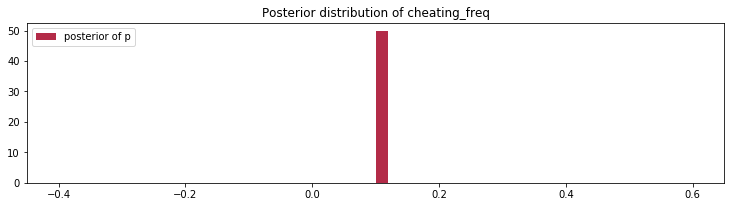

In [8]:
# Plot the results
figsize(12.5, 10)

#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(True)

plt.hist(samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of p", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title("Posterior distribution of cheating_freq")